# IRIS DATASET

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np

from helpers import *

In [2]:
X, y = load_iris(return_X_y=True)
y = y - 1

In [3]:
X, test_X, y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)

In [4]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(X)
test_X_embedded = tsne.fit_transform(test_X)

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
test_X_pca = pca.fit_transform(test_X)

In [5]:
dev = qml.device("default.qutrit", wires=4)

In [6]:
def rot(weights, wires):
    qml.TRY(weights[0], wires=wires, subspace=[0, 1])
    qml.TRY(weights[1], wires=wires, subspace=[0, 2])
    qml.TRY(weights[2], wires=wires, subspace=[0, 1])
    qml.TRZ(weights[3], wires=wires, subspace=[0, 2])
    qml.TRZ(weights[4], wires=wires, subspace=[0, 1])
    qml.TRY(weights[5], wires=wires, subspace=[0, 1])
    qml.TRY(weights[6], wires=wires, subspace=[0, 2])
    qml.TRY(weights[7], wires=wires, subspace=[0, 1])

obs = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], requires_grad=False)

def layer(point, weights):
    p_len = len(point)
    
    for i in range(p_len):
        rot(weights[i], wires=i)
    for i in range(p_len, 0):
        qml.TAdd(wires=[i % p_len, (i-1) % p_len])

@qml.qnode(dev)
def iris_model(point, weights, n_layers=1):

    # Angle embedding
    for i, p in enumerate(point):
        qml.TRX(p, wires=i, subspace=[0, 1])

    for n in range(n_layers):
        layer(point, weights[n])

    return qml.expval(qml.THermitian(obs, wires=0))

In [7]:
n_layers = 1
n_features = 4

weights = np.random.normal(size=(n_layers, n_features, 8))
our_preds = make_predictions(X, iris_model, weights, classes=3)

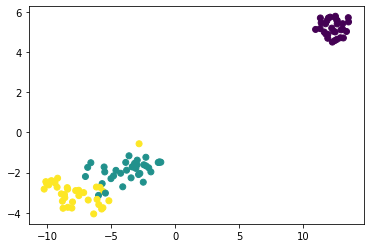

In [8]:
plot_data(X_embedded, y)

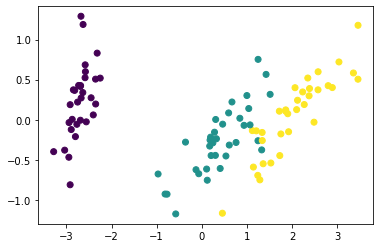

In [22]:
plot_data(X_pca, y)

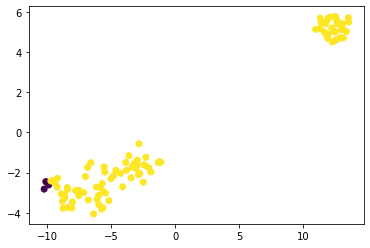

In [9]:
plot_data(X_embedded, our_preds)

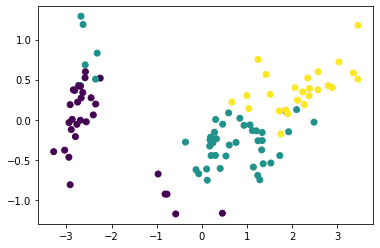

In [23]:
plot_data(X_pca, our_preds)

In [11]:
loss = make_loss_function(X, y, iris_model)

In [12]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, iris_model, weights, classes=3)
        print(f"Loss at iteration {it:2} = {_loss: .10f}  Accuracy = {compute_accuracy(our_preds, y): .2f}")
    loss_track.append(_loss)

Loss at iteration  0 =  0.7781364640  Accuracy =  0.35
Loss at iteration  5 =  0.6514284658  Accuracy =  0.35
Loss at iteration 10 =  0.5816363836  Accuracy =  0.35
Loss at iteration 15 =  0.5268403237  Accuracy =  0.35
Loss at iteration 20 =  0.4725670013  Accuracy =  0.35
Loss at iteration 25 =  0.4180540537  Accuracy =  0.36
Loss at iteration 30 =  0.3699101067  Accuracy =  0.39
Loss at iteration 35 =  0.3333494798  Accuracy =  0.43
Loss at iteration 40 =  0.3082042642  Accuracy =  0.52
Loss at iteration 45 =  0.2915214809  Accuracy =  0.57
Loss at iteration 50 =  0.2803816516  Accuracy =  0.57
Loss at iteration 55 =  0.2727429342  Accuracy =  0.62
Loss at iteration 60 =  0.2673308068  Accuracy =  0.62
Loss at iteration 65 =  0.2633707648  Accuracy =  0.62
Loss at iteration 70 =  0.2603873567  Accuracy =  0.63
Loss at iteration 75 =  0.2580813515  Accuracy =  0.63
Loss at iteration 80 =  0.2562588105  Accuracy =  0.63
Loss at iteration 85 =  0.2547903017  Accuracy =  0.63
Loss at it

In [13]:
our_preds = make_predictions(X, iris_model, weights, classes=3)
test_preds = make_predictions(test_X, iris_model, weights, classes=3)
print(f"Training prediction accuracy: {compute_accuracy(our_preds, y)}")
print(f"Testing prediction accuracy: {compute_accuracy(test_preds, test_y)}")

Training prediction accuracy: 0.69
Testing prediction accuracy: 0.66


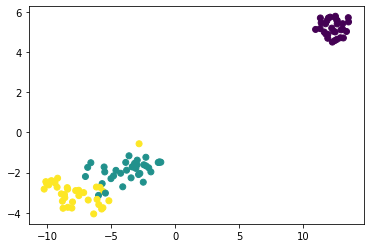

In [14]:
plot_data(X_embedded, y)

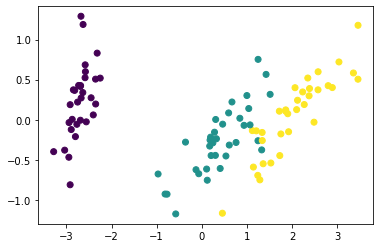

In [24]:
plot_data(X_pca, y)

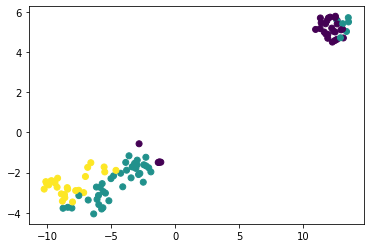

In [15]:
plot_data(X_embedded, our_preds)

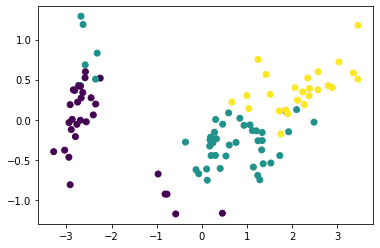

In [25]:
plot_data(X_pca, our_preds)

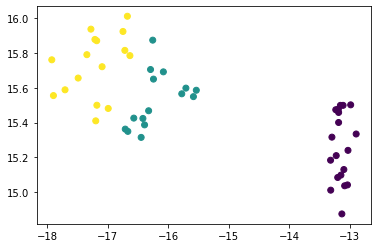

In [16]:
plot_data(test_X_embedded, test_y)

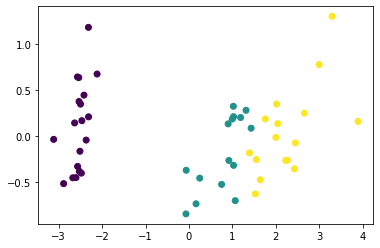

In [26]:
plot_data(test_X_pca, test_y)

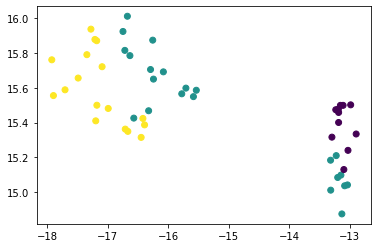

In [17]:
plot_data(test_X_embedded, test_preds)

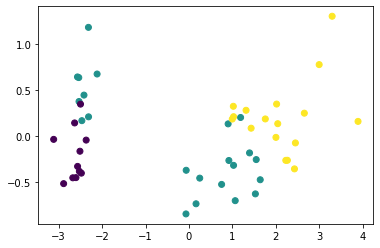

In [27]:
plot_data(test_X_pca, test_preds)